# Content and structure of documents

In [1]:
import os

from tqdm import tqdm
import spacy
import pandas as pd
import matplotlib.pyplot as plt

class BaseArticleDataset:
    def __init__(self, data_dir: str = 'data', language: str = 'en', subtask: int = 2, split: str = 'train'):
        self.language = language
        self.subtask = subtask
        self.split = split
        self.label_file_path = os.path.join(data_dir, language, f'{split}-labels-subtask-{subtask}.txt')
        self.article_dir_path = os.path.join(data_dir, language, f'{split}-articles-subtask-{subtask}')
        self.df = self._create_article_dataframe()

    def _create_article_dataframe(self) -> pd.DataFrame:
        text = []

        for fil in tqdm(filter(lambda x: x.endswith('.txt'), os.listdir(self.article_dir_path))):
            id, txt = fil[7:].split('.')[0], \
                      open(os.path.join(self.article_dir_path, fil), 'r', encoding='utf-8').read()
            text.append((id, txt))

        return pd.DataFrame(text, columns=['id', 'raw_text']) \
            .astype({'id': 'int', 'raw_text': 'str'}) \
            .set_index('id')

    def separate_title_content(self, remove_raw_data_col: bool = False) -> None:
        # TODO: Improve behavior by:
        #   1) Remove trailing whitespaces and breaklines
        #   2) Separate on single breakline "\n"
        #   3) Remove trailing whitespaces and breaklines for title and content again
        self.df[['title', 'content']] = self.df.raw_text.str.split('\n\n', 1, expand=True)

        if remove_raw_data_col:
            self.df.drop('raw_text', axis=1, inplace=True)

/home/juanbermeo/anaconda3/envs/Framing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the Data

In [2]:
semeval_data = BaseArticleDataset(
    data_dir=os.path.join('..', '..', 'data'),
    language='en', subtask=2, split='train')

433it [00:00, 29213.32it/s]


In [3]:
semeval_data.df

,raw_text
id,
765982381,Julian Assange\n\nDuring World War II Cardinal...
766942310,Who ‘Won’ the Trump-Kim Summit?\n\nLast week’s...
706777811,Black Death: ‘It’s 100 % Likely’ It Spreads To...
779394730,"Hundreds of Priests Accused in Pennsylvania, C..."
758472954,"Beware sonic weapon attacks, US tells citizens..."
...,...
761334950,A Dismal Record: Why Are They Destroying the N...
833042063,Chelsea Handler Admits She’s ‘Very Sexually At...
999000145,"Trump: ""If You Don't Want To Be Saying The Wor..."


# Summary of findings
 * Articles in the different datasets are of different sizes:
    * English dataset tends to have articles around 1000 tokens, with the majority being under 3000-3500
    * Italian articles have around 500 tokens, with the majority under 1500
    * Russian articles have around 250 tokens, with the majority under 1500-2000
 * Articles seem to come from fringe rather unreliable sources of news. This is probably because they reflect a specific frame and bias in it more strongly
 * There are minor errors in the dataset such as:
    * Some titles are not appropriately parsed with "\n\n".
    * Some articles are duplicated.
    * Some articles also contain not relevant text such as text from banners or sponsored articles within the article (see article 999001280 in english).
 * It should be possible to separate title and content with the following steps:
    * Remove trailing whitespaces and breaklines
    * Separate on single breakline "\n"
    * Remove trailing whitespaces and breaklines for title and content again
 * Russian articles seem to be better parsed and structured.
    * For example, it is possible to separate title, subtitle, and content
    * Also seems to be better split into paragraphs, which happens much less often for english and italian.
 * For many articles, a breakline identifies a change of paragraph. However, this patterns does not always hold for some exceptions.
    * A solution when we need the whole paragraph would be to merge the first two paragraphs when the first one is only one sentece long and that sentence is short.
 * For some articles, the order of the paragraph is wrong due to the structure of the website
    * [730019938](https://vdare.com/posts/suspect-in-westerville-oh-murder-of-two-white-cops-named-as-quentin-lamar-smith-apparently-black)
    * [725276027](https://vdare.com/posts/kritarchs-patti-saris-and-mark-goldsmith-sabotage-immigration-enforcement)
    * [711716996](https://vdare.com/posts/patti-saris-strikes-again-indonesian-illegals-who-have-been-here-since-the-90s-get-to-say)


# Check distribution of lengths per dataset

In [4]:
semeval_data_en = BaseArticleDataset(
    data_dir=os.path.join('..', '..', 'data'),
    language='en', subtask=2, split='train')
en_nlp = spacy.load('en_core_web_sm')

semeval_data_it = BaseArticleDataset(
    data_dir=os.path.join('..', '..', 'data'),
    language='it', subtask=2, split='train')
it_nlp = spacy.load('it_core_news_sm')

semeval_data_ru = BaseArticleDataset(
    data_dir=os.path.join('..', '..', 'data'),
    language='ru', subtask=2, split='train')
ru_nlp = spacy.load('ru_core_news_sm')

433it [00:00, 28568.59it/s]
227it [00:00, 32796.22it/s]
143it [00:00, 21169.15it/s]


In [5]:
def plot_histogram_num_tokens(doc_list, nlp, title):
    num_tokens = [len(doc) for doc in nlp.pipe(doc_list, n_process=2)]
    pd.Series(num_tokens).plot.hist(bins=30, density=True)
    plt.title(title)
    plt.xlabel("Number of tokens")

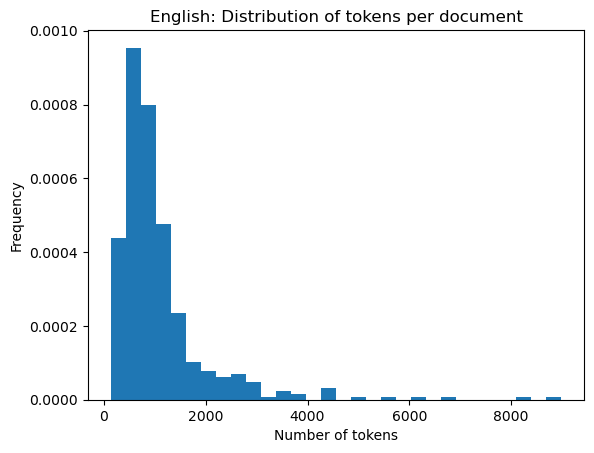

In [6]:
plot_histogram_num_tokens(doc_list=semeval_data_en.df.raw_text.tolist(), nlp=en_nlp,
                          title="English: Distribution of tokens per document")

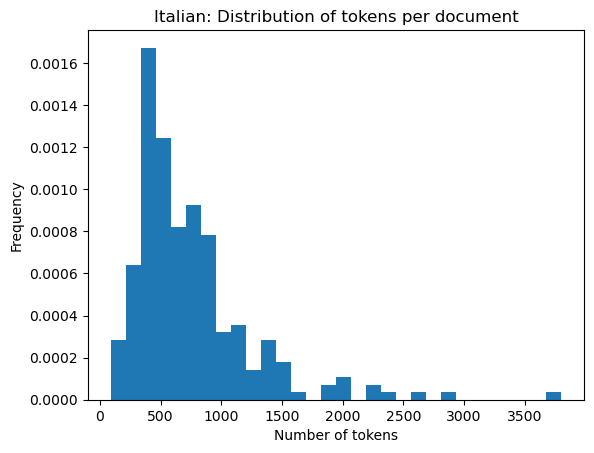

In [7]:
plot_histogram_num_tokens(doc_list=semeval_data_it.df.raw_text.tolist(), nlp=it_nlp,
                          title="Italian: Distribution of tokens per document")

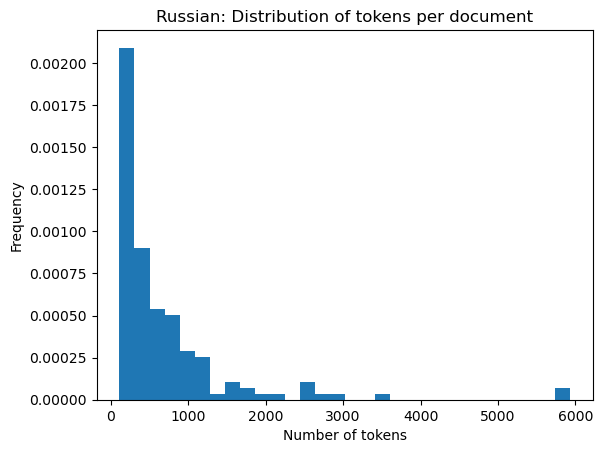

In [8]:
plot_histogram_num_tokens(doc_list=semeval_data_ru.df.raw_text.tolist(), nlp=ru_nlp,
                          title="Russian: Distribution of tokens per document")

## Verify all titles are properly separated

In [9]:
semeval_data.separate_title_content()

Text(0.5, 0, 'length')

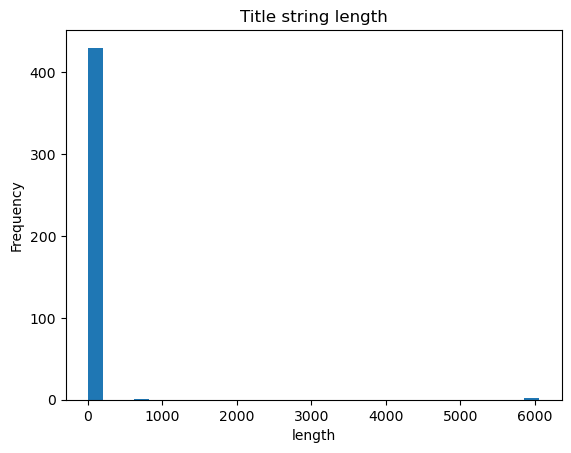

In [10]:
semeval_data.df.title.str.len().plot.hist(bins=30, title="Title string length")
plt.xlabel('length')

There is at least a couple of articles with overly long titles, most likely not properly parsed

In [11]:
max_title_length = semeval_data.df.title.str.len().quantile(0.99)
max_title_length
Dataset
semeval_data.df.title[semeval_data.df.title.str.len() < max_title_length]\
    .str.len().plot.hist(bins=30, title="Title string length")
plt.xlabel('length')

NameError: name 'Dataset' is not defined

This seems a bit more expected. Let's check samples on quartiles and verify if they are indeed titles or not

In [ ]:
pd.DataFrame(semeval_data.df.title[semeval_data.df.title.str.len() >= max_title_length])

In [ ]:
semeval_data.df.raw_text.loc[725824328]

In [ ]:
semeval_data.df.title.loc[725824328]

According to this [website](https://sigforum.com/eve/forums/a/tpc/f/320601935/m/3550057634), the actual title is: **"The Photo That Never Saw The Light of Day: Obama With Farrakhan In 2005"**. Hard to tell the delimiter for this case

In [ ]:
semeval_data.df.title.loc[764715911]

According to this [website](http://www.invexnews.com/item-361622-after-calling-for-guns-amp-ammo-confisca) the title is correct

In [ ]:
semeval_data.df.title[704856340]

Again another long title, but it seems correct.

In [ ]:
semeval_data.df.title[698092698]

In [ ]:
semeval_data.df.title[999000878]

This reveals a second problem of duplicates documents in the dataset :O

According to the this [website](https://investortimes.com/freedomoutpost/las-vegas-shooting-third-timeline-emerges/) the full title is: "**Las Vegas Shooting: A THIRD Timeline Emerges**".

**Overall, we can fix the problem with some noise by separating very long with "\n" instead of "\n\n", or hard code the titles for these articles**

### Check title length behavior in Russian and Italian

In [ ]:
semeval_data_ru = BaseArticleDataset(
    data_dir=os.path.join('..', '..', 'data'),
    language='ru', subtask=2, split='train')
semeval_data_ru.separate_title_content()

semeval_data_it = BaseArticleDataset(
    data_dir=os.path.join('..', '..', 'data'),
    language='it', subtask=2, split='train')
semeval_data_it.separate_title_content()

In [ ]:
print(semeval_data.df.shape)
print(semeval_data_ru.df.shape)
print(semeval_data_it.df.shape)

In [ ]:
semeval_data_ru.df.title.str.len().plot.hist(bins=30, title="Title string length")
plt.xlabel('length')

In [ ]:
semeval_data_it.df.title.str.len().plot.hist(bins=30, title="Title string length")
plt.xlabel('length')

Let's check title that contain breaklines or that are over 150 lines characters long

In [ ]:
semeval_data_it.df[semeval_data_it.df.title.str.contains('\n')]

In [ ]:
semeval_data_it.df[(semeval_data_it.df.title.str.len() > 150) & (semeval_data_it.df.title.str.contains('\n'))]

In [ ]:
print(semeval_data_it.df.title[26294])

According to this [website](https://www.linkiesta.it/2022/07/third-act-anziani-attivismo-clima-ambiente/) the title is the first line

In [ ]:
print(semeval_data_it.df.title[26301])

According to this [website](https://www.agi.it/estero/news/2022-08-04/mosca-dietro-covid-vaiolo-scimmie-gli-usa-17660932/), again the title is the first line

It stands to reason then that the following two steps should yield the right separation of title and content for Italian and English

 * Remove trailing whitespaces and breaklines
 * Separate on single breakline "\n"
 * Remove trailing whitespaces and breaklines for title and content again


In [ ]:
semeval_data_ru.df[(semeval_data_ru.df.title.str.len() > 150) & (semeval_data_ru.df.title.str.contains('\n'))]

In [ ]:
print(semeval_data_ru.df.title[2444])

In [ ]:
print(semeval_data_ru.df.raw_text[2444])

For this [article](https://www.kp.ru/daily/27147/4241476/) it actually seems to be well parsed and that the second line of the title is in fact a subtitle

In [ ]:
print(semeval_data_ru.df.raw_text[24109])


Russian articles are well parsed and usually a breakline indicates the presence of a subtitle (was often the case for the articles in the previous list). For russian, the previous preprocessing of the other two languages is not as much a necessity, though it still separates title from subtitle

## Check for other long titles and verify further quality of parsing

In [ ]:
pd.DataFrame(semeval_data.df.title[semeval_data.df.title.str.len().between(120, max_title_length)])

In [ ]:
semeval_data.df.title[999000135]

In [ ]:
print(semeval_data.df.raw_text[999000135])

In [ ]:
semeval_data.df.title[999000133]

In [ ]:
print(semeval_data.df.raw_text[999000133])

In [ ]:
semeval_data.df.title[999001280]

In [ ]:
print(semeval_data.df.raw_text[999001280])

Everything seems ok

## Check for titles that contain breaklines (possibly badly parsed articles)

In [ ]:
semeval_data.df[semeval_data.df.title.str.contains('\n')]

The only ones that have breaklines are the ones we had already identified

# Check if there is a pattern of paragraph structure

It seems like each breakline follows the paragraph structure of the source document and how it is presented in the website. However, there are some issues with this parsing and the pattern not always holds:

### Do breaklines identifyy separate paragraphs

This seems to be the case for the following examples

   * [765982381](https://www.newagebd.net/print/article/43964)
   * [725276027](https://vdare.com/posts/kritarchs-patti-saris-and-mark-goldsmith-sabotage-immigration-enforcement)
   * [738542398](https://theintercept.com/2017/02/02/trumps-cia-chief-selects-major-torture-operative-to-be-agencys-deputy-director/)
   * Correct but first paragraph is not really a paragraph [765029945](https://bluntforcetruth.com/news/stop-comparing-immigration-enforcement-to-the-holocaust/)


It is not the case for the following examples
   * [765385479](https://www.wsws.org/en/articles/2018/06/19/john-j19.html)
   * [832959523](https://www.moonofalabama.org/2019/03/how-theresa-may-botched-brexit.html): Again, a weird parsing or separation of sentences
   * [999000878](https://investortimes.com/freedomoutpost/las-vegas-shooting-third-timeline-emerges/): Terrible parsing of sentences and paragraphs

A solution when we need the whole paragraph would be to merge the first two paragraphs when the first one is only one sentece long and that sentence is short.

### Document has the wrong order

Compare the document in the [website](https://vdare.com/posts/impeach-kritarch-patti-saris-for-illegally-trying-to-stop-deportations) and the one in the dataset.

In [ ]:
print(semeval_data.df.loc[702111021].raw_text)

The paragraphs are clearly out of order and the title was not parsed. It is possible this website had a different structure resulting in the wrong parsing of the article. The same holds for all articles of that website:

 - [730019938](https://vdare.com/posts/suspect-in-westerville-oh-murder-of-two-white-cops-named-as-quentin-lamar-smith-apparently-black)
 - [725276027](https://vdare.com/posts/kritarchs-patti-saris-and-mark-goldsmith-sabotage-immigration-enforcement)
 - [711716996](https://vdare.com/posts/patti-saris-strikes-again-indonesian-illegals-who-have-been-here-since-the-90s-get-to-say)